In [1]:
!pip -q install rdkit-pypi

In [2]:
import ast

import pandas as pd
import numpy as np

import tensorflow as tf
import keras
from keras import layers

import matplotlib.pyplot as plt
from rdkit import Chem, RDLogger
from rdkit.Chem.Draw import MolsToGridImage

RDLogger.DisableLog("rdApp.*")

In [33]:
df = pd.read_csv(r"dataset\250k_rndm_zinc_drugs_clean_3.csv")
df['smiles'] = df['smiles'].apply(lambda s: s.replace('\n', ''))
df.head()
# df = df[:1000].copy()

,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182


In [44]:
# sort df in the decending order of logp
dfp = df.sort_values(by='logP', ascending=False).reset_index(drop=True) # sort by logP
dfp.head()


# make an additional column of 5 labels , based on the evalue of logP, 1 to 5, 1 being the lowest and 5 being the highest
dfp['logP_class'] = pd.qcut(dfp['logP'], 5, labels=False) + 1
dfp['logP_class'].value_counts()




logP_class
1    49894
4    49893
3    49893
2    49888
5    49887
Name: count, dtype: int64

In [50]:
#randomly take 2000 samples from the dataset
dfn = dfp.sample(10000, random_state=42).reset_index(drop=True)
dfn['logP_class'].value_counts()


logP_class
3    2045
4    2014
1    2011
2    1972
5    1958
Name: count, dtype: int64

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw

# Convert SMILES to RDKit molecule object
# mol = Chem.MolFromSmiles(smiles)

# # Generate a 2D depiction of the molecule
# img = Draw.MolToImage(mol, size=(300, 300))
# dfn['images'] = [None]*len(dfn)
#loop through all molecules and save the images
for i, smiles in enumerate(dfn['smiles']):
    mol = Chem.MolFromSmiles(smiles)
    img = Draw.MolToImage(mol, size=(300, 300))
    #change from RGB to 
    dfn['images'][i] = np.array(img)
    # dfn['logP_class'] = dfn['logP_class']
    
     
    

In [62]:
dfn.to_csv(r'dfn.csv', index=False)

In [59]:
mol = Chem.MolFromSmiles(dfn['smiles'][0])
img = Draw.MolToImage(mol, size=(300, 300))
type(img)

#comvert img to array
img = np.array(img)
img.shape

(300, 300, 3)

In [48]:
dfp.head()

,smiles,logP,qed,SAS,logP_class
0,CC[N+]1(CC)c2cc(/N=C/c3ccccc3)c(/C=C/c3ccccc3)...,8.25210,0.141146,3.607573,5
1,CCN1C=Cc2ccccc2/C1=C\C1=C/C(=C/c2sc3ccc(C)cc3[...,7.99422,0.337508,3.573732,5
2,CCN1/C(=C/C2=C/C(=C/c3sc4ccccc4[n+]3CC)CC(C)(C...,7.81210,0.356125,3.223738,5
3,CC[n+]1c(-c2cc(C(F)(F)F)cc(C(F)(F)F)c2)csc1Nc1...,7.81050,0.285041,2.956857,5
4,FC(F)(F)c1cccc(Nc2scc(-c3ccc(Cl)cc3)[n+]2CCc2c...,7.36110,0.296217,2.516464,5


In [47]:
dfp['logP_class'].value_counts()

logP_class
1    49894
4    49893
3    49893
2    49888
5    49887
Name: count, dtype: int64

In [4]:
def molecule_from_smiles(smiles):
    # MolFromSmiles(m, sanitize=True) should be equivalent to
    # MolFromSmiles(m, sanitize=False) -> SanitizeMol(m) -> AssignStereochemistry(m, ...)
    molecule = Chem.MolFromSmiles(smiles, sanitize=False)

    # If sanitization is unsuccessful, catch the error, and try again without
    # the sanitization step that caused the error
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        Chem.SanitizeMol(molecule, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ flag)

    Chem.AssignStereochemistry(molecule, cleanIt=True, force=True)
    return molecule

SMILES:	CCc1ccc(CNC(=O)c2ccc(-c3nccnc3N3CCCCC3)cc2)cc1
logP:	4.6263
qed:	0.6265585492769999
Molecule:


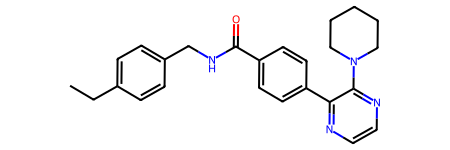

In [5]:
print(f"SMILES:\t{df.smiles[99]}\nlogP:\t{df.logP[99]}\nqed:\t{df.qed[99]}")
molecule = molecule_from_smiles(df.iloc[99].smiles)
print("Molecule:")
molecule

In [6]:
SMILE_CHARSET = '["C", "B", "F", "I", "H", "O", "N", "S", \
                  "P", "Cl", "Br"]'             
bond_mapping = {
    "SINGLE": 0,
    0: Chem.BondType.SINGLE,
    "DOUBLE": 1,
    1: Chem.BondType.DOUBLE,
    "TRIPLE": 2,
    2: Chem.BondType.TRIPLE,
    "AROMATIC": 3,
    3: Chem.BondType.AROMATIC,
}
SMILE_CHARSET = ast.literal_eval(SMILE_CHARSET)

MAX_MOLSIZE = max(df['smiles'].str.len())
SMILE_to_index = dict((c, i) for i, c in enumerate(SMILE_CHARSET))
index_to_SMILE = dict((i, c) for i, c in enumerate(SMILE_CHARSET))
atom_mapping = dict(SMILE_to_index)
atom_mapping.update(index_to_SMILE)

print("Max molecule size: {}".format(MAX_MOLSIZE))
print("Character set Length: {}".format(len(SMILE_CHARSET)))

Max molecule size: 105
Character set Length: 11


## Hyperparameters

In [7]:
BATCH_SIZE = 32
EPOCHS =10

VAE_LR = 5e-4
NUM_ATOMS = 120 # Maximum number of atoms

ATOM_DIM = len(SMILE_CHARSET)  # Number of atom types
BOND_DIM = 4 + 1  # Number of bond types
LATENT_DIM = 435  # Size of the latent space

In [8]:
def smiles_to_graph(smiles):
    '''
    Reference: https://keras.io/examples/generative/wgan-graphs/
    '''
    # Converts SMILES to molecule object
    molecule = Chem.MolFromSmiles(smiles)

    # Initialize adjacency and feature tensor
    adjacency = np.zeros((BOND_DIM, NUM_ATOMS, NUM_ATOMS), "float32")
    features = np.zeros((NUM_ATOMS, ATOM_DIM), "float32")

    # loop over each atom in molecule
    for atom in molecule.GetAtoms():
        i = atom.GetIdx()
        atom_type = atom_mapping[atom.GetSymbol()]
        features[i] = np.eye(ATOM_DIM)[atom_type]
        # loop over one-hop neighbors
        for neighbor in atom.GetNeighbors():
            j = neighbor.GetIdx()
            bond = molecule.GetBondBetweenAtoms(i, j)
            bond_type_idx = bond_mapping[bond.GetBondType().name]
            adjacency[bond_type_idx, [i, j], [j, i]] = 1

    # Where no bond, add 1 to last channel (indicating "non-bond")
    # Notice: channels-first
    adjacency[-1, np.sum(adjacency, axis=0) == 0] = 1

    # Where no atom, add 1 to last column (indicating "non-atom")
    features[np.where(np.sum(features, axis=1) == 0)[0], -1] = 1

    return adjacency, features

def graph_to_molecule(graph):
    '''
    Reference: https://keras.io/examples/generative/wgan-graphs/
    '''
    # Unpack graph
    adjacency, features = graph

    # RWMol is a molecule object intended to be edited
    molecule = Chem.RWMol()

    # Remove "no atoms" & atoms with no bonds
    keep_idx = np.where(
        (np.argmax(features, axis=1) != ATOM_DIM - 1)
        & (np.sum(adjacency[:-1], axis=(0, 1)) != 0)
    )[0]
    features = features[keep_idx]
    adjacency = adjacency[:, keep_idx, :][:, :, keep_idx]

    # Add atoms to molecule
    for atom_type_idx in np.argmax(features, axis=1):
        atom = Chem.Atom(atom_mapping[atom_type_idx])
        _ = molecule.AddAtom(atom)

    # Add bonds between atoms in molecule; based on the upper triangles
    # of the [symmetric] adjacency tensor
    (bonds_ij, atoms_i, atoms_j) = np.where(np.triu(adjacency) == 1)
    for (bond_ij, atom_i, atom_j) in zip(bonds_ij, atoms_i, atoms_j):
        if atom_i == atom_j or bond_ij == BOND_DIM - 1:
            continue
        bond_type = bond_mapping[bond_ij]
        molecule.AddBond(int(atom_i), int(atom_j), bond_type)

    # Sanitize the molecule; for more information on sanitization, see
    # https://www.rdkit.org/docs/RDKit_Book.html#molecular-sanitization
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    # Let's be strict. If sanitization fails, return None
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        return None

    return molecule

In [16]:
print(df.iloc[2].smiles)

a,f = smiles_to_graph(df.iloc[29].smiles)
print("Adjacency matrix:", a.shape)
print("Feature matrix:", f.shape)

N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)cc2)cc1
Adjacency matrix: (5, 120, 120)
Feature matrix: (120, 11)


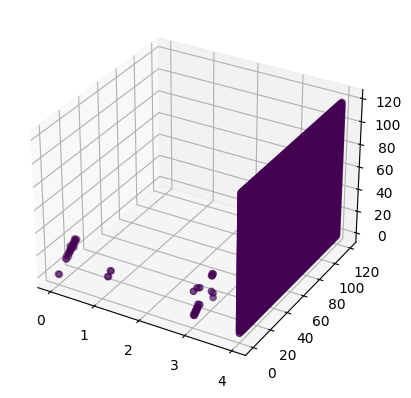

In [15]:

matrix_3d = a.copy()  # replace this with your actual matrix

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x, y, z = matrix_3d.nonzero()
c = matrix_3d[x, y, z]  # color values

ax.scatter(x, y, z, c=c)
plt.show()

## Build Dataloader

In [17]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, data, mapping, max_len, batch_size=6, shuffle=True):
        """
        Initialization
        """
        self.data = data
        self.indices = self.data.index.tolist()
        self.mapping = mapping
        self.max_len = max_len
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        if (index + 1) * self.batch_size > len(self.indices):
            self.batch_size = len(self.indices) - index * self.batch_size
        # Generate one batch of data
        # Generate indices of the batch
        index = self.indices[index * self.batch_size : (index + 1) * self.batch_size]
        # Find list of IDs
        batch = [self.indices[k] for k in index]
        mol_features, mol_property = self.data_generation(batch)

        return mol_features, mol_property

    def on_epoch_end(self):

        """
        Updates indexes after each epoch
        """
        self.indices = np.arange(len(self.data))  # Modify to update indices correctly
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def load(self, idx):
        """
        Load molecules adjacency matrix and features matrix from SMILE representation 
        and their respective SAS value.
        """
        qed = self.data.loc[idx]['qed']

        adjacency, features = smiles_to_graph(self.data.loc[idx]['smiles'])

        return adjacency, features, qed
    
    def data_generation(self, batch):
        x1 = np.empty((self.batch_size, BOND_DIM, self.max_len, self.max_len))
        x2 = np.empty((self.batch_size, self.max_len, len(self.mapping)))
        x3 = np.empty((self.batch_size, ))
        
        for i, batch_id in enumerate(batch):
            x1[i,], x2[i,], x3[i,] = self.load(batch_id)

        return (np.array(x1), np.array(x2)), np.array(x3)



##  Generate training set

In [34]:
train_df = df.sample(frac=0.75,random_state=42) #random state is a seed value
test_df = df.drop(train_df.index)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [19]:
class RelationalGraphConvLayer(tf.keras.layers.Layer):
    def __init__(
        self,
        units=128,
        activation="relu",
        use_bias=False,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.units = units
        self.activation = tf.keras.activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = tf.keras.initializers.get(kernel_initializer)
        self.bias_initializer = tf.keras.initializers.get(bias_initializer)
        self.kernel_regularizer = tf.keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = tf.keras.regularizers.get(bias_regularizer)

    def build(self, input_shape):
        bond_dim = input_shape[0][1]
        atom_dim = input_shape[1][2]

        self.kernel = self.add_weight(
            shape=(bond_dim, atom_dim, self.units),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            trainable=True,
            name="W",
            dtype=tf.float32,
        )

        if self.use_bias:
            self.bias = self.add_weight(
                shape=(bond_dim, 1, self.units),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                trainable=True,
                name="b",
                dtype=tf.float32,
            )

        self.built = True

    def call(self, inputs, training=False):
        adjacency, features = inputs
        # Aggregate information from neighbors
        x = tf.matmul(adjacency, features[:, None, :, :])
        # Apply linear transformation
        x = tf.matmul(x, self.kernel)
        if self.use_bias:
            x += self.bias
        # Reduce bond types dim
        x_reduced = tf.reduce_sum(x, axis=1)
        # Apply non-linear transformation
        return self.activation(x_reduced)

In [20]:
def get_encoder(gconv_units, latent_dim, adjacency_shape, feature_shape, dense_units,dropout_rate ):
    '''
    Reference: https://keras.io/examples/generative/wgan-graphs/
    '''
    adjacency = tf.keras.layers.Input(shape=adjacency_shape)
    features = tf.keras.layers.Input(shape=feature_shape)

    # Propagate through one or more graph convolutional layers
    features_transformed = features
    for units in gconv_units:
        features_transformed = RelationalGraphConvLayer(units)(
            [adjacency, features_transformed]
        )
    # Reduce 2-D representation of molecule to 1-D
    x = tf.keras.layers.GlobalAveragePooling1D()(features_transformed)

    # Propagate through one or more densely connected layers
    for units in dense_units:
        x = tf.keras.layers.Dense(units, activation="relu")(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    z_mean = tf.keras.layers.Dense(latent_dim, dtype="float32", name="z_mean")(x)
    log_var = tf.keras.layers.Dense(latent_dim, dtype="float32", name="log_var")(x)
    
    encoder = tf.keras.Model([adjacency, features], [z_mean, log_var], name="encoder")

    return encoder

class Symmetrify(tf.keras.layers.Layer):
    def call(self, inputs):
        return (inputs + tf.transpose(inputs, (0, 1, 3, 2))) / 2

def get_decoder(dense_units, dropout_rate, latent_dim, adjacency_shape, feature_shape):
    '''
    Reference: https://keras.io/examples/generative/wgan-graphs/
    '''
    latent_inputs = tf.keras.Input(shape=(latent_dim,))

    x = latent_inputs
    for units in dense_units:
        x = tf.keras.layers.Dense(units, activation="tanh")(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)

    # Map outputs of previous layer (x) to [continuous] adjacency tensors (x_adjacency)
    x_adjacency = tf.keras.layers.Dense(np.prod(adjacency_shape))(x)
    x_adjacency = tf.keras.layers.Reshape(adjacency_shape)(x_adjacency)
    # Symmetrify tensors in the last two dimensions
    x_adjacency = Symmetrify()(x_adjacency)
    x_adjacency = tf.keras.layers.Softmax(axis=1)(x_adjacency)

    # Map outputs of previous layer (x) to [continuous] feature tensors (x_features)
    x_features = tf.keras.layers.Dense(np.prod(feature_shape))(x)
    x_features = tf.keras.layers.Reshape(feature_shape)(x_features)
    x_features = tf.keras.layers.Softmax(axis=2)(x_features)

    decoder = tf.keras.Model(latent_inputs, outputs=[x_adjacency, x_features], name="decoder")

    return decoder

## Build Sampling layer

In [21]:
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_log_var)[0]
        dim = tf.shape(z_log_var)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Build the VAE


In [22]:
class MoleculeGenerator(tf.keras.Model):
    def __init__(self, encoder, decoder, max_len, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.property_prediction_layer = tf.keras.layers.Dense(1)
        self.max_len = max_len

        self.train_total_loss_tracker = tf.keras.metrics.Mean(name="train_total_loss")
        self.val_total_loss_tracker = tf.keras.metrics.Mean(name="val_total_loss")
        # self.train_total_loss_tracker = []
        # self.val_total_loss_tracker = []
    
    def train_step(self, data):
        
        mol_features, mol_property = data
        # print(mol_features, mol_property, data)
        graph_real = mol_features
        self.batch_size = tf.shape(mol_property)[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, property_prediction, \
             reconstruction_adjacency, reconstruction_features = self(mol_features,
                                                                             training=True)
            graph_generated = [reconstruction_adjacency, reconstruction_features]
            total_loss = self.calculate_loss(z_log_var,
                                             z_mean,
                                             mol_property,
                                             property_prediction,
                                             graph_real,
                                             graph_generated,
                                             is_train=True)

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.train_total_loss_tracker.update_state(total_loss)
        # self.train_total_loss_tracker.append(total_loss)
        return {
            "train_loss": self.train_total_loss_tracker.result()
        }

    def test_step(self, data):
        mol_features, mol_property = data
        z_mean, z_log_var, property_prediction, \
        reconstruction_adjacency, reconstruction_features = self(mol_features,
                                                                training=False)
        total_loss = self.calculate_loss(z_log_var,
                                        z_mean,
                                        mol_property, 
                                        property_prediction,
                                        graph_real=mol_features,
                                        graph_generated=[reconstruction_adjacency, 
                                                        reconstruction_features],
                                        is_train=False)

        self.val_total_loss_tracker.update_state(total_loss)
        # self.val_total_loss_tracker.append(total_loss)
        return {
            "val_loss": self.val_total_loss_tracker.result()
        }

    def calculate_loss(self,
                       z_log_var,
                       z_mean,
                       mol_property,
                       property_prediction,
                       graph_real,
                       graph_generated,
                       is_train):
        adjacency_real, features_real = graph_real
        adjacency_generated, features_generated = graph_generated
        
        adjacency_reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.categorical_crossentropy(
                                                        adjacency_real,
                                                        adjacency_generated
                                                        ),
                                                        axis=(1,2)
                    )
            )
        features_reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.categorical_crossentropy(
                                                        features_real,
                                                        features_generated
                                                        ),
                                                        axis=(1)
                    )
            )
        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), 1)
        kl_loss = tf.reduce_mean(kl_loss)
         
    
        property_prediction_loss = tf.reduce_mean(
    tf.keras.losses.binary_crossentropy(tf.expand_dims(mol_property, axis = 1), property_prediction)
)
        
    

        if is_train:
            graph_loss = self._gradient_penalty(graph_real, graph_generated)
        else:
            graph_loss = 0

        return kl_loss + property_prediction_loss + graph_loss + adjacency_reconstruction_loss + features_reconstruction_loss

    def _gradient_penalty(self, graph_real, graph_generated):
        # Unpack graphs
        adjacency_real, features_real = graph_real
        adjacency_generated, features_generated = graph_generated

        # Generate interpolated graphs (adjacency_interp and features_interp)
        alpha = tf.random.uniform([self.batch_size])
        alpha = tf.reshape(alpha, (self.batch_size, 1, 1, 1))
        alpha = tf.cast(alpha, tf.float32)
        adjacency_real = tf.cast(adjacency_real, tf.float32)
        adjacency_interp = (adjacency_real * alpha) + (1 - alpha) * adjacency_generated
        alpha = tf.reshape(alpha, (self.batch_size, 1, 1))
        alpha = tf.cast(alpha, tf.float32)
        features_real = tf.cast(features_real, tf.float32)
        features_interp = (features_real * alpha) + (1 - alpha) * features_generated

        # Compute the logits of interpolated graphs
        with tf.GradientTape() as tape:
            tape.watch(adjacency_interp)
            tape.watch(features_interp)
            _, _, logits, _,_ = self(
                [adjacency_interp, features_interp], training=True
            )

        # Compute the gradients with respect to the interpolated graphs
        grads = tape.gradient(logits, [adjacency_interp, features_interp])
        # Compute the gradient penalty
        grads_adjacency_penalty = (1 - tf.norm(grads[0], axis=1)) ** 2
        grads_features_penalty = (1 - tf.norm(grads[1], axis=2)) ** 2
        return tf.reduce_mean(
            tf.reduce_mean(grads_adjacency_penalty, axis=(-2, -1))
            + tf.reduce_mean(grads_features_penalty, axis=(-1))
        )
    
    def inference(self, batch_size):
        z = tf.random.normal((batch_size, LATENT_DIM))
        reconstruction_adjacency, reconstruction_features = self.decoder.predict(z)
        # obtain one-hot encoded adjacency tensor
        adjacency = tf.argmax(reconstruction_adjacency, axis=1)
        adjacency = tf.one_hot(adjacency, depth=BOND_DIM, axis=1)
        # Remove potential self-loops from adjacency
        adjacency = tf.linalg.set_diag(adjacency, tf.zeros(tf.shape(adjacency)[:-1]))
        # obtain one-hot encoded feature tensor
        features = tf.argmax(reconstruction_features, axis=2)
        features = tf.one_hot(features, depth=ATOM_DIM, axis=2)
        return [
            graph_to_molecule([adjacency[i].numpy(), features[i].numpy()])
            for i in range(batch_size)
        ]
    
    def call(self, inputs):
        z_mean, log_var = self.encoder(inputs)
        z = Sampling()([z_mean, log_var])

        reconstruction_adjacency, reconstruction_features = self.decoder(z)

        property_prediction = self.property_prediction_layer(z_mean)

        return z_mean, log_var, property_prediction, reconstruction_adjacency, reconstruction_features

## Train the model

In [35]:
train_loader = DataGenerator(
    data=train_df[:10000],
    mapping = SMILE_to_index, 
    max_len = NUM_ATOMS,
    batch_size=BATCH_SIZE
)

validation_loader = DataGenerator(
    data=test_df[:10000],
    mapping = SMILE_to_index, 
    max_len = NUM_ATOMS,
    batch_size=BATCH_SIZE
    )

In [36]:
train_df

,smiles,logP,qed,SAS
0,C[NH+]1CCC(NC(=O)[C@H]2CCN(c3ccc(Cl)c(Cl)c3)C2...,1.13960,0.793487,3.843395
1,C[C@H]1C[C@H]1C(=O)N1CCN(C(=O)NCC(C)(C)[NH+]2C...,0.34360,0.784932,4.232355
2,Cc1ccc([C@@H]2CSCCN2Cc2cc3cnn(C(C)C)c3nc2Cl)o1,4.85712,0.569373,3.463493
3,C=CCc1ccccc1OC(C)=O,2.34040,0.401613,1.943724
4,C[C@@H](c1nccs1)N(C)C(=O)c1cccc(NC(=O)C2CCCC2)c1,4.10500,0.843003,2.639230
...,...,...,...,...
187086,CCNS(=O)(=O)[C@@H]1CC[NH+](Cc2nc3cc(F)ccc3o2)C1,0.06340,0.836341,4.494904
187087,C[C@H]([C@@H](C)Cl)[C@@H]1CCOC2(CCSCC2)C1,3.94220,0.673750,4.874562
187088,C#CCNC(=O)[C@H]1CC(=O)N(c2ccc(Br)c(C)c2)C1,1.85982,0.863124,2.810700
187089,CCc1ccc(C(=O)N(CCC#N)CC2CC2)cc1,3.01488,0.776560,2.048951


In [37]:
vae_optimizer = tf.keras.optimizers.Adam(
    learning_rate=VAE_LR
)

encoder = get_encoder(
    gconv_units=[9],
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
    latent_dim=LATENT_DIM,
    dense_units=[512],
    dropout_rate=0.0,
)
decoder = get_decoder(
    dense_units=[128, 256, 512],
    dropout_rate=0.2,
    latent_dim=LATENT_DIM,
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM)
)

model = MoleculeGenerator(encoder, 
                          decoder,
                          MAX_MOLSIZE)

model.compile(vae_optimizer)

history = model.fit(train_loader,
                    epochs=5,
                    validation_data=validation_loader)


Epoch 1/5


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


313/313 ━━━━━━━━━━━━━━━━━━━━ 314s 967ms/step - train_loss: 69120.6797 - loss: 0.0000e+00 - train_total_loss: 69005.0000 - val_total_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_train_total_loss: 0.0000e+00 - val_val_total_loss: 69183.3125
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 209s 666ms/step - train_loss: 69235.4062 - loss: 0.0000e+00 - train_total_loss: 69302.2969 - val_total_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_train_total_loss: 0.0000e+00 - val_val_total_loss: 69174.7969
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 208s 662ms/step - train_loss: 70175.9062 - loss: 0.0000e+00 - train_total_loss: 70087.8438 - val_total_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_train_total_loss: 0.0000e+00 - val_val_total_loss: 69342.9922
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 207s 659ms/step - train_loss: 70142.8125 - loss: 0.0000e+00 - train_total_loss: 71640.7969 - val_total_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_train_total_loss: 0.0000e+00 - val_val_total_loss: 69525.8672
Epoch 5/5


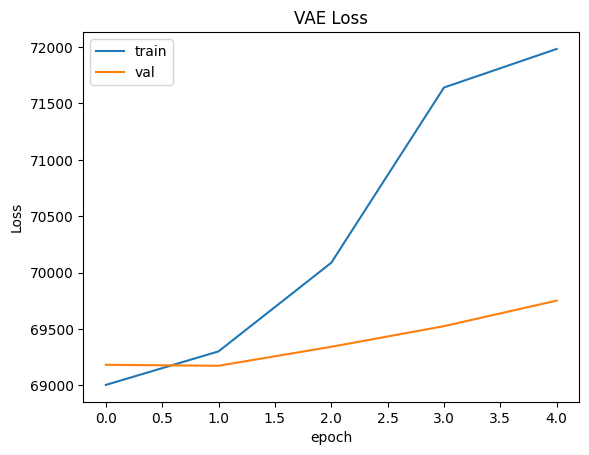

In [38]:
plt.plot(history.history['train_total_loss'])
plt.plot(history.history['val_val_total_loss'])
plt.title('VAE Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Model Inferencing

We would be inferring our model to predict over random latent space and try to generate 100 new valid molecules.

### Generate unique Molecules with the model

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/stepWARNING:tensorflow:6 out of the last 40 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001DE57BFD6C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


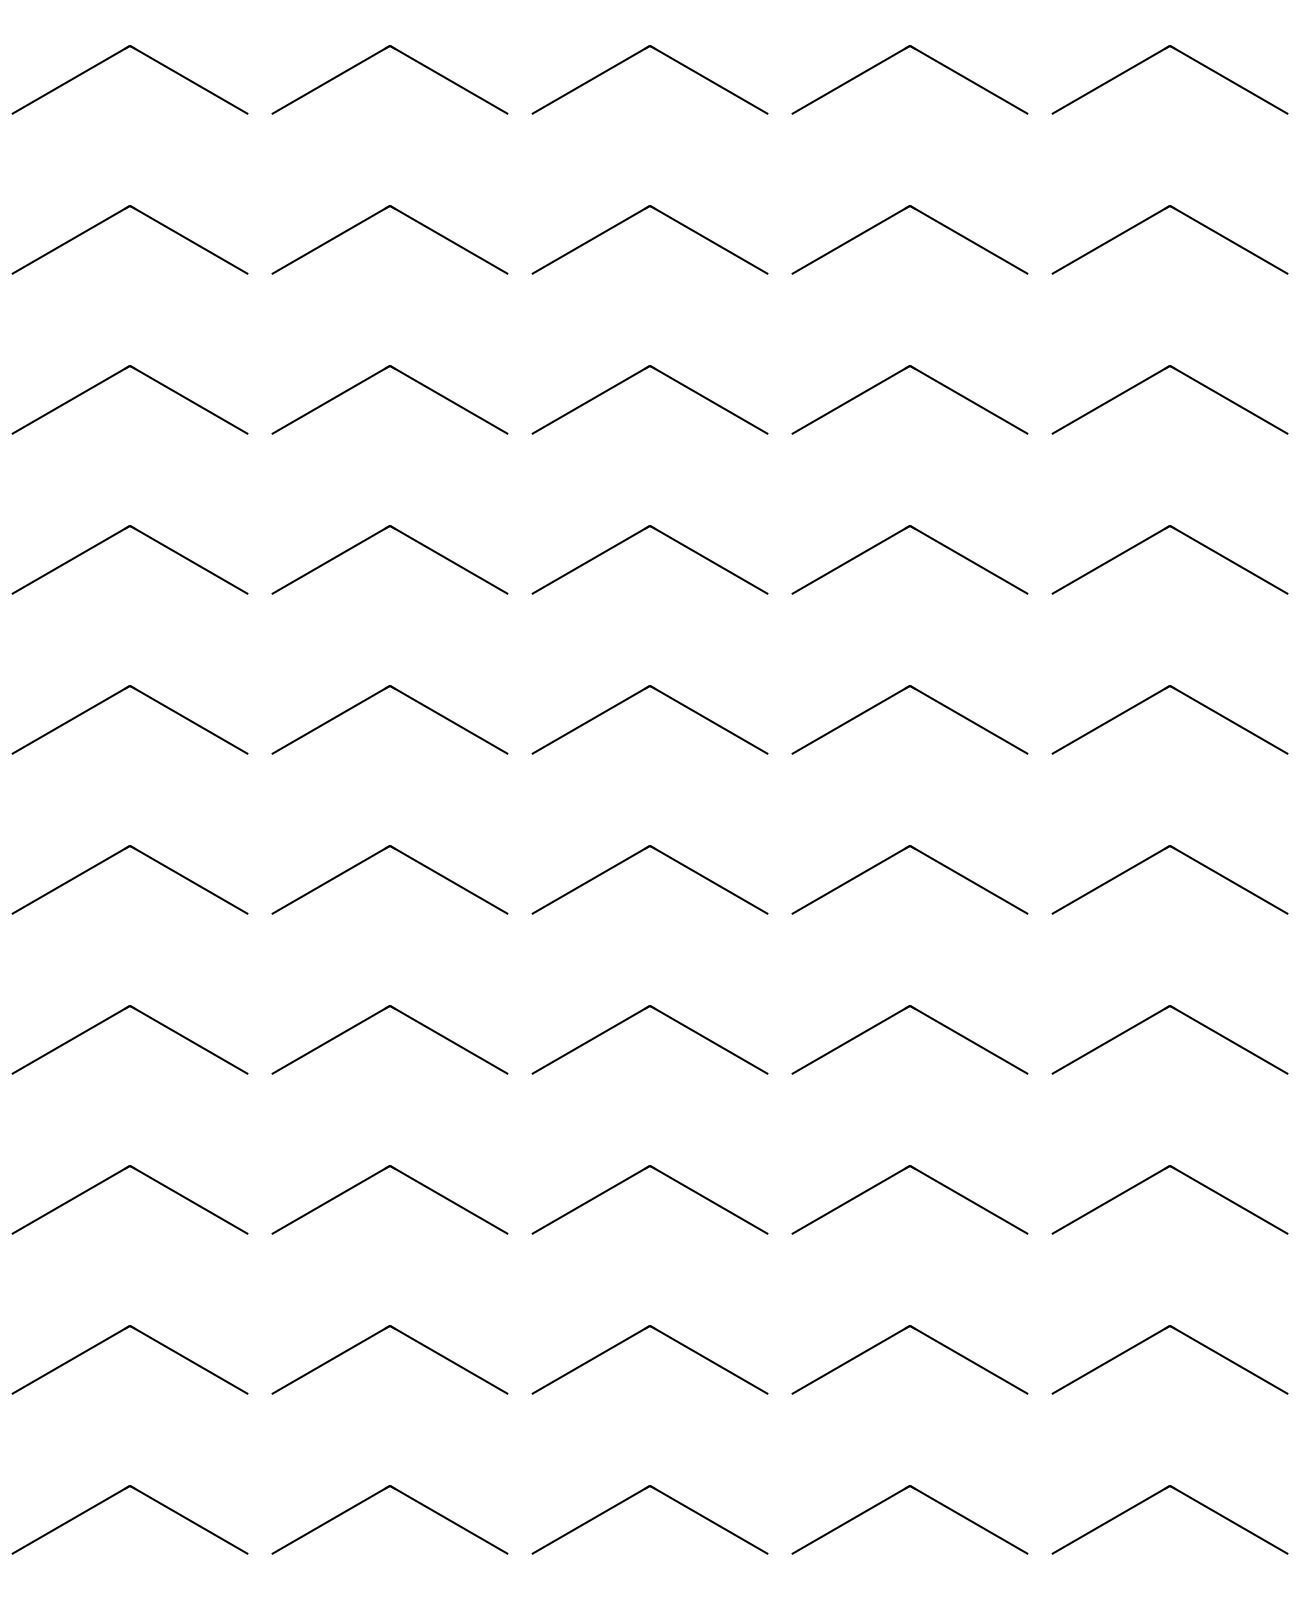

In [39]:
molecules = model.inference(100)

MolsToGridImage(
    [m for m in molecules if m is not None][:100], molsPerRow=5, subImgSize=(260, 160)
)

### Display latent space clusters with respect to molecular properties (SAS)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


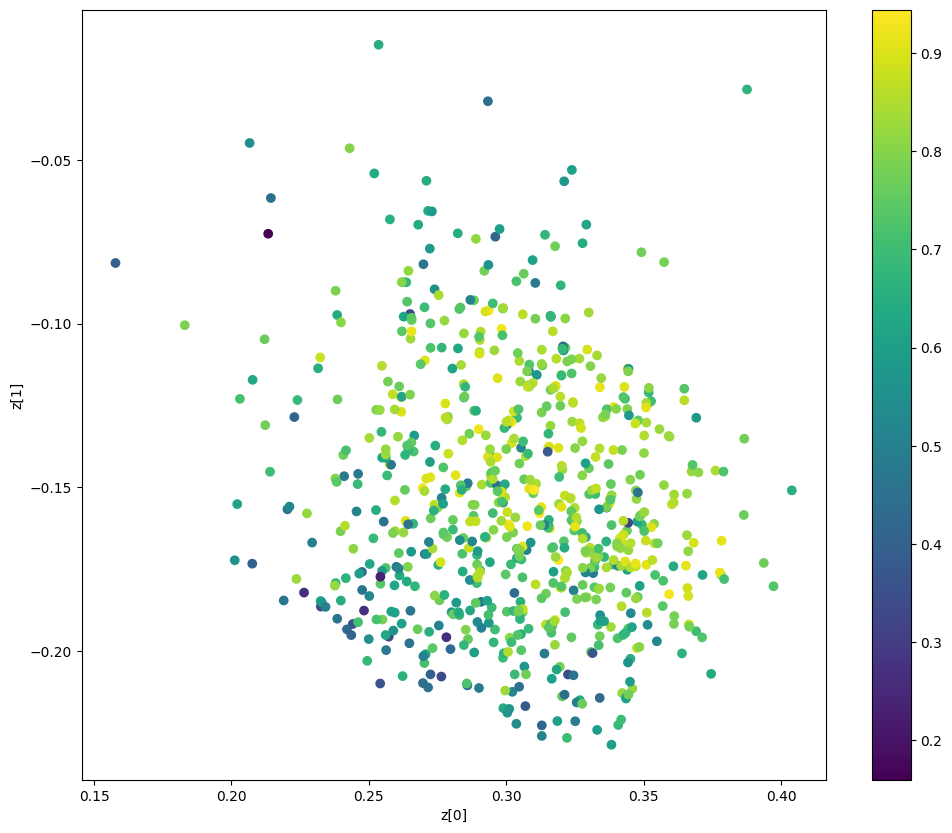

In [112]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the property in the latent space
    z_mean, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


train_data = DataGenerator(
                            data=train_df,
                            mapping = SMILE_to_index, 
                            max_len = NUM_ATOMS,
                            batch_size=8000
                        )
x_train, y_train = next(iter(train_data))
plot_label_clusters(model, x_train, y_train)

## Conclusion
